<a href="https://colab.research.google.com/github/inesbenomar18/ERNet_secondment/blob/master/Secondment_ERnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ERnet Transformer

# Table of Contents

- [1. Install packages](#install)
- [2. Download files](#download)
- [3. Functions](#functions)
- [4. Inference](#inference)
    - [a. Single images](#single)
    - [b. Batch processing](#batch)

<a id='install'></a>
## 1. Install packages

In [1]:
!pip install sknw timm einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 33.6 MB/s eta 0:00:00


<a id='download'></a>
## 2. Download files

In [2]:
# architectures
!mkdir -p archs
!wget https://raw.githubusercontent.com/charlesnchr/ERnet-v2/main/Training/archs/swinir_rcab_arch.py -P Training/archs
!wget https://raw.githubusercontent.com/charlesnchr/ERnet-v2/main/Training/archs/rcan_arch.py -P Training/archs

# inference code
!wget https://raw.githubusercontent.com/charlesnchr/ERnet-v2/main/Inference/model_evaluation.py -P Inference
!wget https://raw.githubusercontent.com/charlesnchr/ERnet-v2/main/Inference/graph_processing.py -P Inference

# models
!mkdir -p models
!wget https://github.com/charlesnchr/ERnet-v2/releases/download/v2.0/20220306_ER_4class_swinir_nch1.pth -P models

# image files
!mkdir -p images
!wget https://github.com/charlesnchr/ERnet-v2/releases/download/v2.0/TestImage1.png -P images
!wget https://github.com/charlesnchr/ERnet-v2/releases/download/v2.0/TestImage2.png -P images
!wget https://github.com/charlesnchr/ERnet-v2/releases/download/v2.0/TestImage3-stack.tif -P images
!wget https://github.com/charlesnchr/ERnet-v2/releases/download/v2.0/TestImage4-stack.tif -P images

--2024-10-18 09:02:01--  https://raw.githubusercontent.com/charlesnchr/ERnet-v2/main/Training/archs/swinir_rcab_arch.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50102 (49K) [text/plain]
Saving to: ‘Training/archs/swinir_rcab_arch.py’

swinir_rcab_arch.py 100%[===================>]  48.93K  --.-KB/s    in 0.008s  

2024-10-18 09:02:01 (5.80 MB/s) - ‘Training/archs/swinir_rcab_arch.py’ saved [50102/50102]

--2024-10-18 09:02:01--  https://raw.githubusercontent.com/charlesnchr/ERnet-v2/main/Training/archs/rcan_arch.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request se

Saving mSG-Sec61b full_0001-1-cropped.png to mSG-Sec61b full_0001-1-cropped.png
Saving mSG-Sec61b full_0002-1-cropped.png to mSG-Sec61b full_0002-1-cropped.png
Saving mSG-Sec61b full_0003-1-cropped.png to mSG-Sec61b full_0003-1-cropped.png


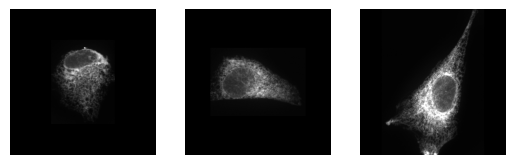

In [3]:
from google.colab import files
from PIL import Image, ImageOps
import io
import os

# Function to pad images to 1024x1024 dimensions
def pad_image_to_1024(img):
    # Define the target size
    target_size = (1024, 1024)

    # Get the current size of the image
    current_size = img.size

    # If the image already fits, return it as is
    if current_size == target_size:
        return img

    # Create a new image (black background) of the target size
    new_img = Image.new("L", target_size, color=0)  # 'L' mode for grayscale and 0 for black

    # Center the original image on the new black background
    paste_position = ((target_size[0] - current_size[0]) // 2, (target_size[1] - current_size[1]) // 2)
    new_img.paste(img, paste_position)

    return new_img

# Upload the images
uploaded_img = files.upload()

# Example: Applying padding to a list of images
padded_images = []
for filename, file_content in uploaded_img.items():
    # Open the uploaded image
    img = Image.open(io.BytesIO(file_content))  # Convert byte content to image
    gray_img = img.convert("L")  # Convert to grayscale
    padded_img = pad_image_to_1024(gray_img)  # Pad the image if necessary
    padded_images.append(padded_img)  # Add the padded image to the list

# Optionally, display the padded images
import matplotlib.pyplot as plt

for i, padded_img in enumerate(padded_images):
    plt.subplot(2, 3, i+1)
    plt.imshow(padded_img, cmap='gray')
    plt.axis('off')
plt.show()

# Save padded images to the directory
output_dir = '/content/output'
os.makedirs(output_dir, exist_ok=True)

padded_filepaths = []
for i, padded_img in enumerate(padded_images):
    filename = f'padded_image_{i+1}.png'
    filepath = os.path.join(output_dir, filename)
    padded_img.save(filepath)
    padded_filepaths.append(filepath)  # Save the path for later use


<a id='functions'></a>
# 3. Functions

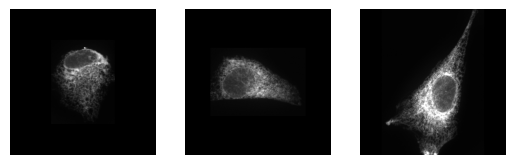

In [4]:
from PIL import Image
import os

# Convert images to grayscale
grayscale_images = []
for path in padded_filepaths:
    img = Image.open(path)  # Open the image
    gray_img = img.convert("L")  # Convert to grayscale
    grayscale_images.append(gray_img)  # Append to the list of grayscale images

# Optionally, display the grayscale images to confirm
import matplotlib.pyplot as plt

for i, gray_img in enumerate(grayscale_images):
    plt.subplot(2, 3, i+1)
    plt.imshow(gray_img, cmap='gray')
    plt.axis('off')
plt.show()

In [5]:
# Create output directory if it doesn't exist
output_dir = '/content/output'
os.makedirs(output_dir, exist_ok=True)

# Save grayscale images to the directory
grayscale_filepaths = []
for i, gray_img in enumerate(grayscale_images):
    filename = f'grayscale_image_{i+1}.png'
    filepath = os.path.join(output_dir, filename)
    gray_img.save(filepath)
    grayscale_filepaths.append(filepath)  # Save the path for later use


In [6]:
%reload_ext autoreload
%autoreload 2

# Imports
import os
import datetime
import math
import time
from skimage import io
import os
from argparse import Namespace
import sys

# Load code from repository (ERnet architecture + inference code)
dirs = ["Training/archs", "Inference"]
[sys.path.append(os.path.abspath(f)) for f in dirs]
from Inference import model_evaluation


def segment(
    exportdir,
    filepaths,
    weka_colours,
    stats_tubule_sheet,
    graph_metrics,
    save_in_original_folders,
    save_input=True,
):
    opt = Namespace()
    opt.root = filepaths
    opt.ext = ["jpg", "png", "tif"]
    opt.stats_tubule_sheet = stats_tubule_sheet
    opt.graph_metrics = graph_metrics
    opt.weka_colours = weka_colours
    opt.save_input = save_input

    opt.exportdir = exportdir
    os.makedirs(exportdir, exist_ok=True)
    opt.jobname = datetime.datetime.utcnow().strftime("%Y%m%d%H%M%S%f")[:-3]

    if stats_tubule_sheet:
        csvfid_path = "%s/%s_stats_tubule_sheet.csv" % (opt.exportdir, opt.jobname)
        opt.csvfid = open(csvfid_path, "w")

    if opt.graph_metrics:
        graphfid_path = "%s/%s_graph_metrics.csv" % (opt.exportdir, opt.jobname)
        opt.graphfid = open(graphfid_path, "w")

    ## model specific
    opt.imageSize = 600
    opt.n_resblocks = 10
    opt.n_resgroups = 3
    opt.n_feats = 64
    opt.reduction = 16
    opt.narch = 0
    opt.norm = None
    opt.nch_in = 1
    opt.nch_out = 4
    opt.cpu = False
    opt.weights = model
    opt.scale = 1

    if save_in_original_folders:
        opt.out = "root"

    print(vars(opt))

    return model_evaluation.EvaluateModel(opt)

<a id='inference'></a>
# 4. Inference

<a id='single'></a>
## a. Example of using ERnet Transformer on single images

In [7]:
exportdir = 'output'
files = ["grayscale_image_1.png"]

for filepath in grayscale_filepaths:
    img = Image.open(filepath)
    print(f"Image size: {img.size}, Mode: {img.mode}")

model = 'models/20220306_ER_4class_swinir_nch1.pth'
weka_colours = False
stats_tubule_sheet = True
graph_metrics = True
save_in_original_folders = True
outpaths = segment(exportdir,grayscale_filepaths,weka_colours,stats_tubule_sheet,graph_metrics,save_in_original_folders,model)


Image size: (1024, 1024), Mode: L
Image size: (1024, 1024), Mode: L
Image size: (1024, 1024), Mode: L
{'root': ['/content/output/grayscale_image_1.png', '/content/output/grayscale_image_2.png', '/content/output/grayscale_image_3.png'], 'ext': ['jpg', 'png', 'tif'], 'stats_tubule_sheet': True, 'graph_metrics': True, 'weka_colours': False, 'save_input': 'models/20220306_ER_4class_swinir_nch1.pth', 'exportdir': 'output', 'jobname': '20241018090246227', 'csvfid': <_io.TextIOWrapper name='output/20241018090246227_stats_tubule_sheet.csv' mode='w' encoding='UTF-8'>, 'graphfid': <_io.TextIOWrapper name='output/20241018090246227_graph_metrics.csv' mode='w' encoding='UTF-8'>, 'imageSize': 600, 'n_resblocks': 10, 'n_resgroups': 3, 'n_feats': 64, 'reduction': 16, 'narch': 0, 'norm': None, 'nch_in': 1, 'nch_out': 4, 'cpu': False, 'weights': 'models/20220306_ER_4class_swinir_nch1.pth', 'scale': 1, 'out': 'root'}
LOADING: Transformer architecture


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


loading checkpoint models/20220306_ER_4class_swinir_nch1.pth


/content/Inference/model_evaluation.py:313: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(opt.weights, map_location=device)


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
/usr/local/lib/python3.10/dist-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))


Saved ['/content/output/grayscale_image_1_out_0000.png', '/content/output/grayscale_image_1_graph.png', '/content/output/grayscale_image_1_hist.png', '/content/output/grayscale_image_2_out_0001.png', '/content/output/grayscale_image_2_graph.png', '/content/output/grayscale_image_2_hist.png', '/content/output/grayscale_image_3_out_0002.png', '/content/output/grayscale_image_3_graph.png', '/content/output/grayscale_image_3_hist.png']


### Visualise result

<Figure size 640x480 with 0 Axes>

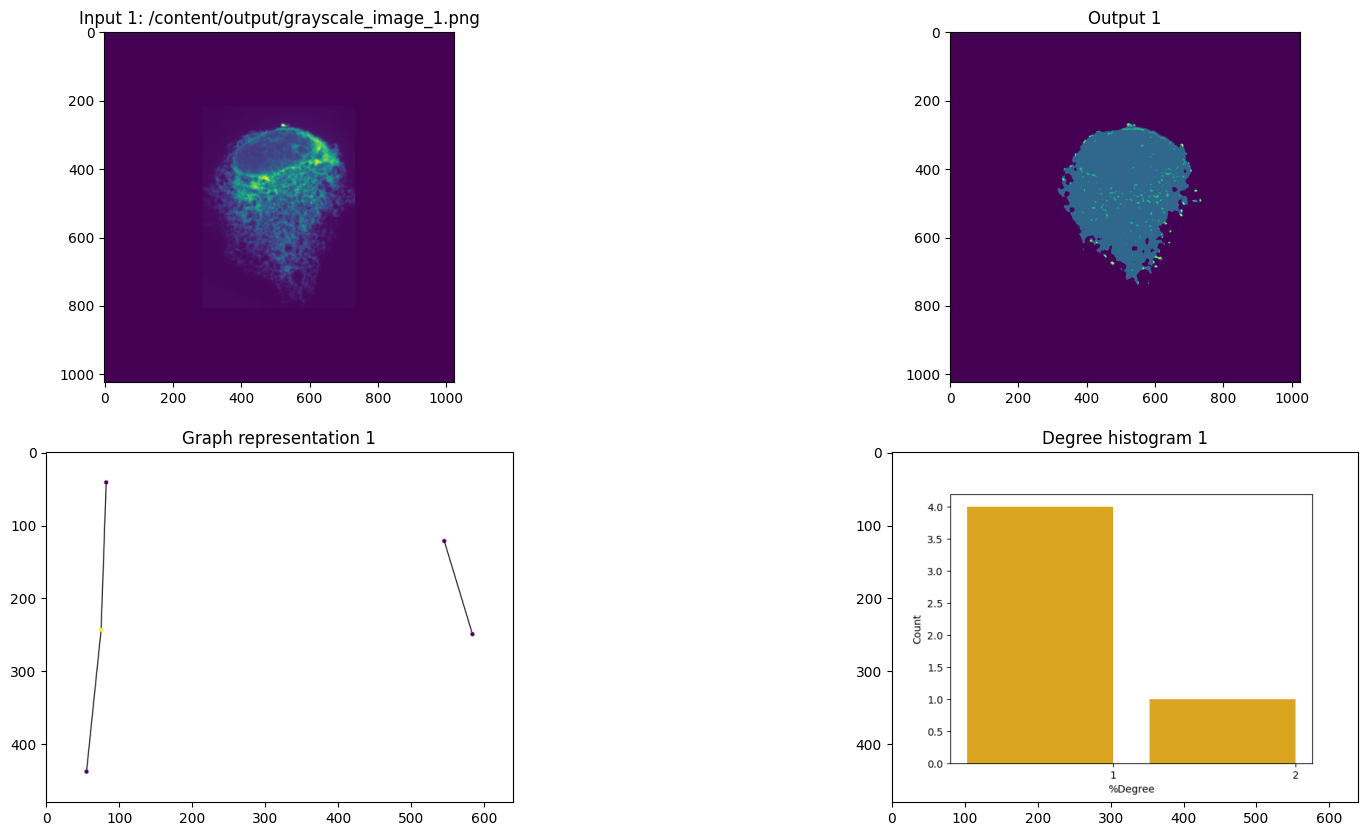

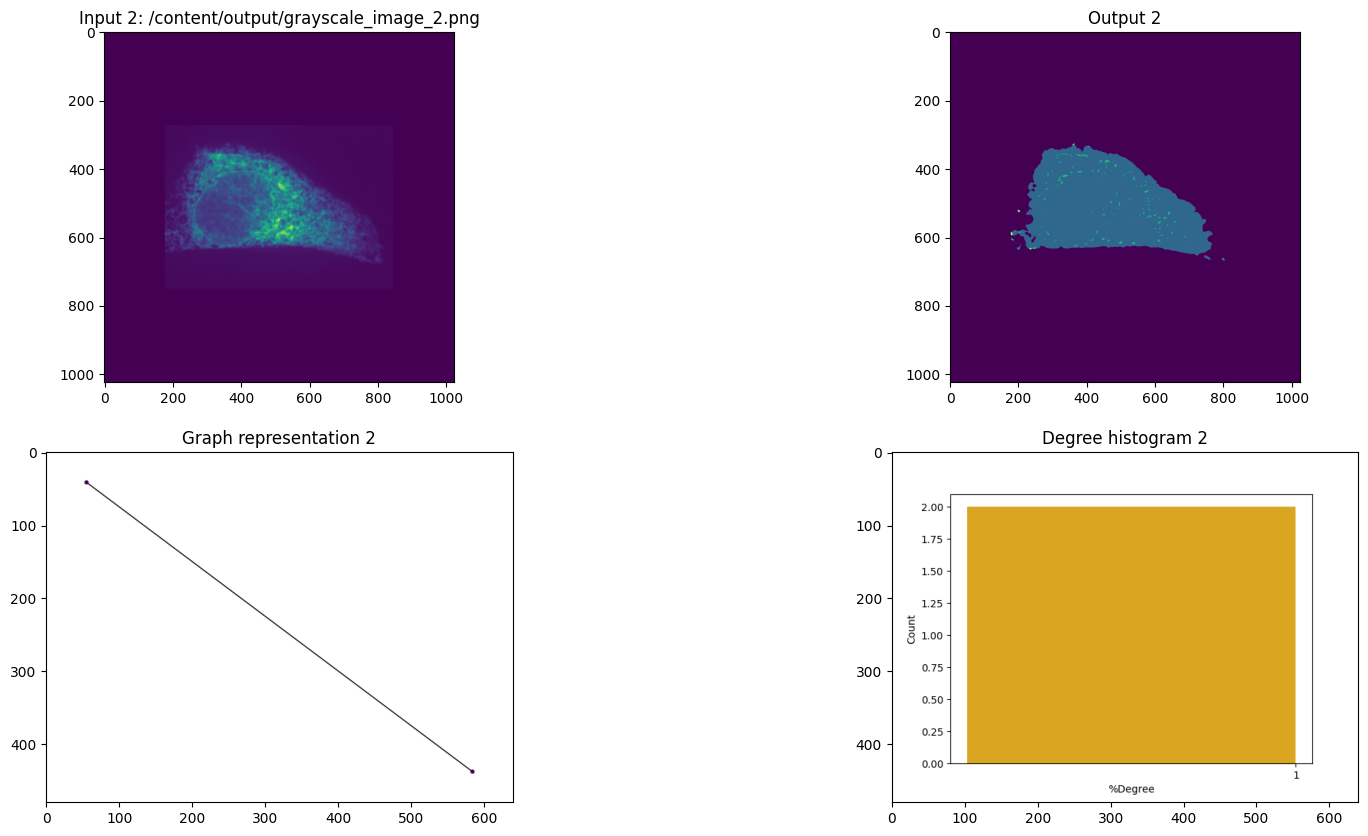

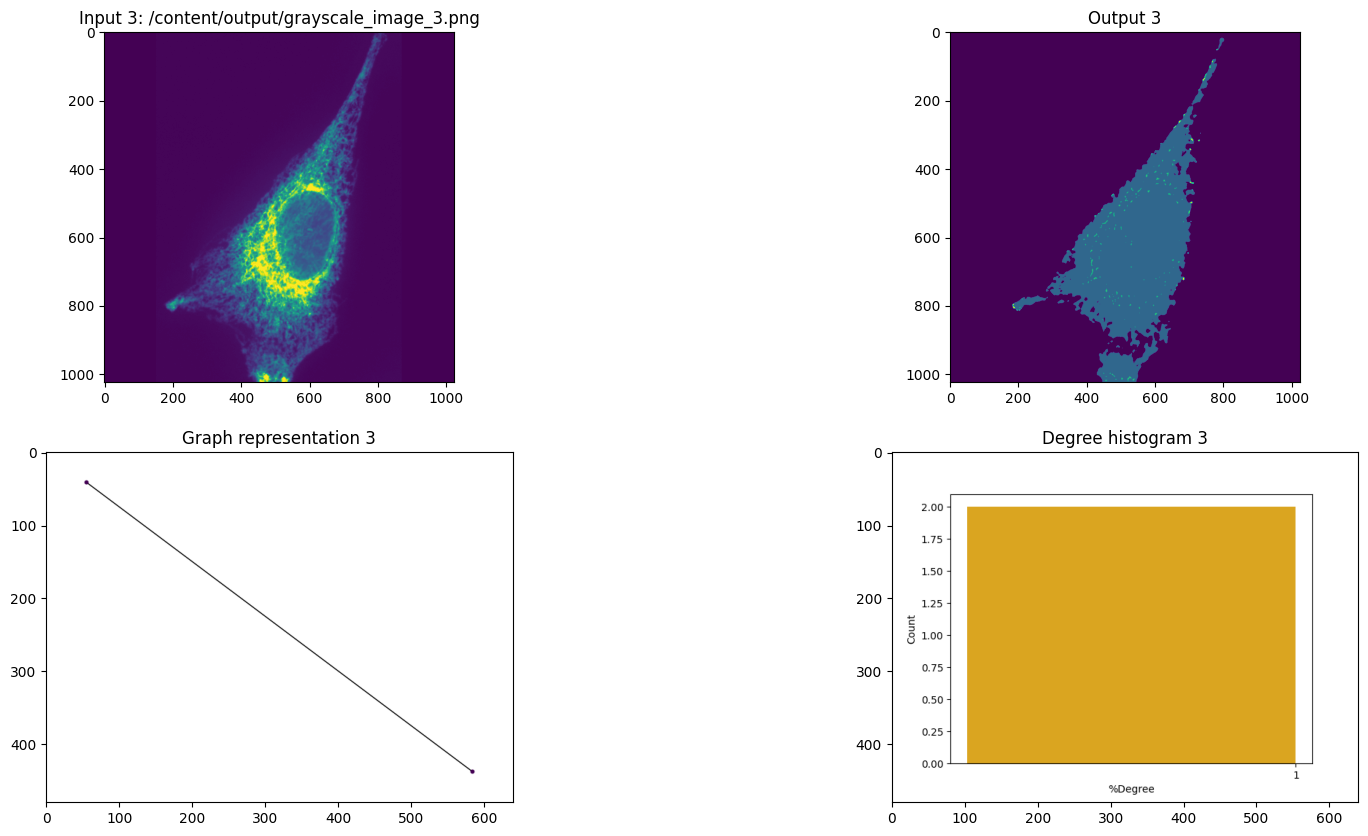

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.clf()

# output files per input file
n = len(outpaths)//len(grayscale_filepaths)

for idx, inpath in enumerate(grayscale_filepaths):

    outpath = [outpaths[i] for i in range(idx*n, (idx+1)*n )]

    plt.figure(figsize=(20,10))
    plt.subplot(221)
    plt.imshow(io.imread(inpath))
    plt.title('Input %d: %s' % (idx+1,inpath))
    plt.subplot(222)
    plt.imshow(io.imread(outpath[0]))
    plt.title('Output %d' % (idx+1))

    plt.subplot(223)
    plt.imshow(io.imread(outpath[1]))
    plt.title('Graph representation %d' % (idx+1))
    plt.subplot(224)
    plt.imshow(io.imread(outpath[2]))
    plt.title('Degree histogram %d' % (idx+1))
plt.show()

<a id='batch'></a>
## b. Example of batch processing

`TestImage3-stack.tif` consists of 5 frames

`TestImage4-stack.tif` consists of 30 frames

In [ ]:
exportdir = 'output'
filepaths = ['images/TestImage3-stack.tif','images/TestImage4-stack.tif']
model = 'models/20220306_ER_4class_swinir_nch1.pth'
weka_colours = False
stats_tubule_sheet = True
graph_metrics = True
save_in_original_folders = True
outpaths = segment(exportdir,filepaths,weka_colours,stats_tubule_sheet,graph_metrics,save_in_original_folders,model)